# Academic Prototyping

_This is the manuscript of Andreas Zeller's tutorial
"Academic Prototyping" at the ESEC/FSE 2022 conference._

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("Z7Z0cdwPS0U")

## About this Tutorial

In our [Fuzzing Book](index.ipynb), we use Python to implement automated testing techniques, and also as the language for most of our test subjects.  Why Python?  The short answer is

> Python made us amazingly _productive_.  Most techniques in this book took **2-3 days** to implement.  This is about **10-20 times faster** than for "classic" languages like C or Java.

A factor of 10–20 in productivity is enormous, almost ridiculous.  Why is that so, and which consequences does this have for research and teaching?

### What I will talk about

In this tutorial, I will demonstrate this by prototyping a _symbolic test generator_ from scratch. This normally would be considered a very difficult task, taking months to build. Yet, developing the code in this chapter took less than two hours – and explaining it takes less than 20 minutes.

We will explore the reasons for this productivity, singling out to _Python_ and _Jupyter notebooks_ as the main drivers. And we will discuss the consequences for academic software development.

### What you will learn

* Using _Python_ and its libraries as language for prototyping
* Using _Jupyter Notebooks_ as a tool for coding and running evaluations
* Understanding where gains in productivity and replicability come from

## The Trouble with Analyzing Compiled Languages

In the course of my career, I have built (and let build) several tools that operate on compiled languages such as C or Java – notably 

* automated debugging tools that would extract and analyze dynamic information from program executions, and
* automated testing tools that would exercise individual applications or functions with (generated) inputs.

What I learned from this experience can be summarized as follows:

1. Instrumenting compiled code is **hard**. You need to plug into existing infrastructures such as the Java or C compilers, find out which code to add, find out how to adapt this to the respective compiler.
2. Capturing information from compiled code is **hard**, too. Again, you need to instrument code (see above), but you also need to make sure the information gets stored (efficiently?), later retrieved and decoded.

All this is immensely bug-prone. There is a good reason why successful test generators assume an absolute minimum of infrastructure (e.g. getting coverage with existing tools, and nothing more).

If you want to go into static or even symbolic analysis, things are even worse. Parsing C and Java code yourself is difficult; for large-scale code, it's next to impossible. Working on some intermediate representation is possible, thanks to the power of existing infrastructures such as Soot. But if you want to extend these, you are in for weeks and weeks of work.

Symbolic analysis is extra hard, as you typically want to operate on an abstraction level that is at least as high as the source code, requiring you to create ties between the symbolic level, the source code level, and the actual machine code. All possible, but hard.

Now, if your focus is to actually analyze large scale code, for instance because

* the domain is very important, and the problems are challenging
* you are in industry and work on safety-critical systems
* you'd like to evaluate some approach on lots of samples in compiled languages

then it may well make sense to _eventually_ apply your approach to large-scale code. But before that, you may want to check whether your approach actually works.

This is where _prototyping_ comes into play. Prototyping means to develop a quick solution to explore the _feasibility_ of some approach:

* to gather feedback from practice
* to quickly _evolve_ an approach
* to show that something may work

In other words, the proof of concept that we typically need to show in our academic world.

## Python is Easy

Python is a high-level language that allows one to focus on the actual _algorithms_ rather than how individual bits and bytes are passed around in memory.  For this book, this is important: We want to focus on how individual techniques work, and not so much their optimization.  Focusing on algorithms allows you to toy and tinker with them, and quickly develop your own.  Once you have found out how to do things, you can still port your approach to some other language or specialized setting.

As an example, take the (in)famous _triangle_ program, which classifies a triangle of lengths $a$, $b$, $c$ into one of three categories.  It reads like pseudocode; yet, we can easily execute it.

In [2]:
def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'equilateral'
        else:
            return 'isosceles #1'
    else:
        if b == c:
            return 'isosceles #2'
        else:
            if a == c:
                return 'isosceles #3'
            else:
                return 'scalene'

Here's an example of executing the `triangle()` function:

In [3]:
triangle(2, 3, 4)

'scalene'

For the remainder of this chapter, we will use the `triangle()` function as ongoing example for a program to be tested.  Of course, the complexity of `triangle()` is a far cry from large systems, and what we show in this chapter will not apply to, say, an ecosystem of thousands of intertwined microservices.  Its point, however, is to show how easy certain techniques can be – if you have the right language and environment.

## Building a Minimal Tester

If you want to test `triangle()` with random values, that's fairly easy to do. Just bring along one of the Python random number generators and throw them into `triangle()`.

In [4]:
from random import randrange

In [5]:
for i in range(10):
    a = randrange(1, 10)
    b = randrange(1, 10)
    c = randrange(1, 10)

    t = triangle(a, b, c)
    print(f"triangle({a}, {b}, {c}) = {repr(t)}")

triangle(1, 6, 1) = 'isosceles #3'
triangle(2, 1, 3) = 'scalene'
triangle(1, 5, 8) = 'scalene'
triangle(3, 2, 7) = 'scalene'
triangle(2, 6, 3) = 'scalene'
triangle(7, 8, 6) = 'scalene'
triangle(5, 7, 7) = 'isosceles #2'
triangle(3, 8, 7) = 'scalene'
triangle(5, 1, 8) = 'scalene'
triangle(8, 4, 8) = 'isosceles #3'


So far, so good – but that's something you can do in pretty much any programming language. What is it that makes Python special?

## Dynamic Analysis in Python: So Easy it Hurts

Dynamic analysis is the ability to track what is happening during program execution.  The Python `settrace()` mechanism allows you to track all code lines, all variables, all values, as the program executes – and all this in a handful of lines of code.  Our `Coverage` class from [the chapter on coverage](Coverage.ipynb) shows how to capture a trace of all lines executed in five lines of code; such a trace easily converts into sets of lines or branches executed.  With two more lines, you can easily track all functions, arguments, variable values, too – see for instance our [chapter on dynamic invariants](DynamicInvariants).  And you can even access the source code of individual functions (and print it out, too!)  All this takes 10, maybe 20 minutes to implement.

Here is a piece of Python that does it all.  We track lines executed, and for every line, we print its source codes and the current values of all local variables:

In [6]:
import sys
import inspect

In [7]:
def traceit(frame, event, arg):
    function_code = frame.f_code
    function_name = function_code.co_name
    lineno = frame.f_lineno
    vars = frame.f_locals

    source_lines, starting_line_no = inspect.getsourcelines(frame.f_code)
    loc = f"{function_name}:{lineno} {source_lines[lineno - starting_line_no].rstrip()}"
    vars = ", ".join(f"{name} = {vars[name]}" for name in vars)

    print(f"{loc:50} ({vars})")

    return traceit

The function `sys.settrace()` registers `traceit()` as a trace function; it will then trace the given invocation of `triangle()`:

In [8]:
def triangle_traced():
    sys.settrace(traceit)
    triangle(2, 2, 1)
    sys.settrace(None)

In [9]:
triangle_traced()

triangle:1 def triangle(a, b, c):                  (a = 2, b = 2, c = 1)
triangle:2     if a == b:                          (a = 2, b = 2, c = 1)
triangle:3         if b == c:                      (a = 2, b = 2, c = 1)
triangle:6             return 'isosceles #1'       (a = 2, b = 2, c = 1)
triangle:6             return 'isosceles #1'       (a = 2, b = 2, c = 1)


In comparison, try to build such a dynamic analysis for, say, C. You can either _instrument_ the code to track all lines executed and record variable values, storing the resulting info in some database.  This will take you _weeks,_ if not _months_ to implement.  You can also run your code through a debugger (step-print-step-print-step-print); but again, programming the interaction can take days.  And once you have the first results, you'll probably realize you need something else or better, so you go back to the drawing board.  Not fun.

Together with a dynamic analysis such as the one above, you can make fuzzing much smarter. Search-based testing, for instance, evolves a population of inputs towards a particular goal, such as coverage. With a good dynamic analysis, you can quickly implement search-based strategies for arbitrary goals.

## Static Analysis in Python: Still Easy

Static analysis refers to the ability to analyze _program code_ without actually executing it. Statically analyzing Python code to deduce any property can be a nightmare, because the language is so highly dynamic. (More on that below.)

If your static analysis does not have to be _sound_, – for instance, because you only use it to _support_ and _guide_ another technique such as  testing – then a static analysis in Python can be very simple.  The `ast` module allows you to turn any Python function into an abstract syntax tree (AST), which you then can traverse as you like.  Here's the AST for our `triangle()` function:

In [10]:
from bookutils import rich_output

In [11]:
import ast

In [12]:
if rich_output():
    # Normally, this will do
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree, indent=4)

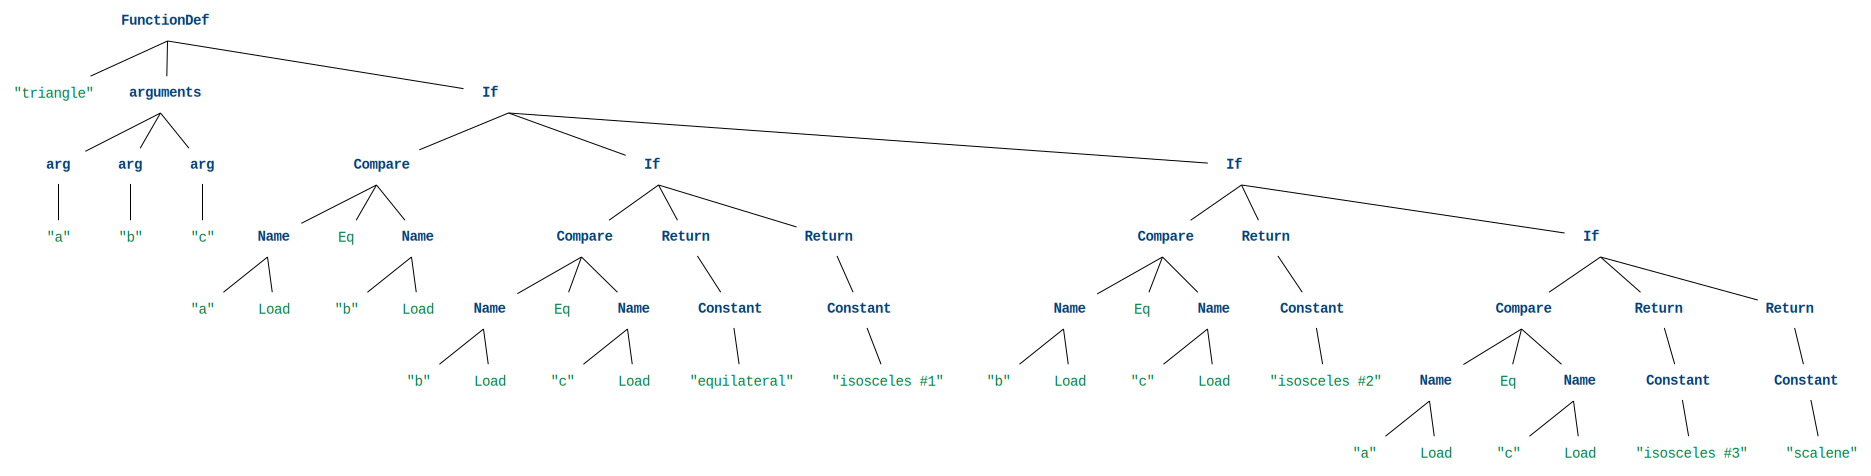

In [13]:
triangle_source = inspect.getsource(triangle)
triangle_ast = ast.parse(triangle_source)
show_ast(triangle_ast)

Now suppose one wants to identify all `triangle` branches and their conditions using static analysis.  You would traverse the AST, searching for `If` nodes, and take their first child (the condition).  This is easy as well:

In [14]:
def collect_conditions(tree):
    conditions = []

    def traverse(node):
        if isinstance(node, ast.If):
            cond = ast.unparse(node.test).strip()
            conditions.append(cond)

        for child in ast.iter_child_nodes(node):
            traverse(child)

    traverse(tree)
    return conditions

Here are the four `if` conditions occurring in the `triangle()` code:

In [15]:
collect_conditions(triangle_ast)

['a == b', 'b == c', 'b == c', 'a == c']

Not only can we extract individual program elements, we can also change them at will and convert the tree back into source code.  Program transformations (say, for instrumentation or mutation analysis) are a breeze.  The above code took five minutes to write.  Again, try that in Java or C.

## Symbolic Reasoning in Python: There's a Package for That

Let's get back to testing.  We have shown how to extract conditions from code.  To reach a particular location in the `triangle()` function, one needs to find a solution for the _path conditions_ leading to that branch.  To reach the last line in `triangle()` (the `'scalene'` branch), we have to find a solution for 
$$a \ne b \land b \ne c \land a \ne c$$


We can make use of a _constraint_ solver for this, such as Microsoft's [_Z3_ solver](https://github.com/Z3Prover/z3):

In [16]:
import z3  # type: ignore

Let us use Z3 to find a solution for the `'scalene'` branch condition:

In [17]:
a = z3.Int('a')
b = z3.Int('b')
c = z3.Int('c')

In [18]:
s = z3.Solver()
s.add(z3.And(a > 0, b > 0, c > 0))  # Triangle edges are positive
s.add(z3.And(a != b, b != c, a != c))  # Our condition
s.check()

sat

Z3 has shown us that there is a solution ("sat" = "satisfiable"). Let us get one:

In [19]:
m = s.model()
m

[a = 1, c = 3, b = 2]

We can use this solution right away for testing the `triangle()` function and find that it indeed covers the `'scalene'` branch. The method `as_long()` converts the Z3 results into numerical values.

In [20]:
triangle(m[a].as_long(), m[b].as_long(), m[c].as_long())

'scalene'

## A Symbolic Test Generator

With what we have seen, we can now build a _symbolic test generator_ – a tool that attempts to systematically create test inputs that cover all paths.  Let us find all conditions we need to solve, by exploring all paths in the tree. We turn these paths to Z3 format right away:

In [21]:
def collect_path_conditions(tree):
    paths = []

    def traverse_if_children(children, context, cond):
        old_paths = len(paths)
        for child in children:
            traverse(child, context + [cond])
        if len(paths) == old_paths:
            paths.append(context + [cond])

    def traverse(node, context):
        if isinstance(node, ast.If):
            cond = ast.unparse(node.test).strip()
            not_cond = "z3.Not(" + cond + ")"

            traverse_if_children(node.body, context, cond)
            traverse_if_children(node.orelse, context, not_cond)

        else:
            for child in ast.iter_child_nodes(node):
                traverse(child, context)

    traverse(tree, [])

    return ["z3.And(" + ", ".join(path) + ")" for path in paths]

In [22]:
path_conditions = collect_path_conditions(triangle_ast)
path_conditions

['z3.And(a == b, b == c)',
 'z3.And(a == b, z3.Not(b == c))',
 'z3.And(z3.Not(a == b), b == c)',
 'z3.And(z3.Not(a == b), z3.Not(b == c), a == c)',
 'z3.And(z3.Not(a == b), z3.Not(b == c), z3.Not(a == c))']

Now all we need to do is to feed these constraints into Z3. We see that we easily cover all branches:

In [23]:
for path_condition in path_conditions:
    s = z3.Solver()
    s.add(a > 0, b > 0, c > 0)
    eval(f"s.check({path_condition})")
    m = s.model()
    print(m, triangle(m[a].as_long(), m[b].as_long(), m[c].as_long()))

[a = 1, c = 1, b = 1] equilateral
[c = 2, a = 1, b = 1] isosceles #1
[c = 2, a = 1, b = 2] isosceles #2
[c = 1, a = 1, b = 2] isosceles #3
[c = 3, a = 1, b = 2] scalene


Success! We have covered all branches of the triangle program!

Now, the above is still very limited – and tailored to the capabilities of the `triangle()` code. A full implementation would actually

* translate entire Python conditions into Z3 syntax (if possible),
* handle more control flow constructs such as returns, assertions, exceptions
* and half a million things more (loops, calls, you name it)

Some of these may not be supported by the Z3 theories.

To make it easier for a constraint solver to find solutions, you could also provide _concrete values_ observed from earlier executions that already are known to reach specific paths in the program.  Such concrete values would be gathered from the tracing mechanisms above, and boom: you would have a pretty powerful and scalable concolic (concrete-symbolic) test generator.

Now, the above might take you a day or two, and as you expand your test generator beyond `triangle()`, you will add more and more features.  The nice part is that every of these features you will invent might actually be a research contribution – something nobody has thought of before.  Whatever idea you might have: you can quickly implement it and try it out in a prototype.  And again, this will be orders of magnitude faster than for conventional languages.

## Replicable Experiments

Using a language like Python alone might make you a productive (and creative) code researcher. As a good scientist, though, you also need _discipline_ in running your experiments. _What exactly did you do to achieve the results as stated in the paper_? This is where my second not-so-secret weapon comes into play: Notebooks.

A Jupyter Notebook can hold _all_ your code (although many prefer an IDE for that); but at the very least, it can _document_ all the steps you did in your experiments, together with _rich text_ that explains the setup and your rationales, and (of course!) rich visualizations and diagrams that visualize your results. This is where Jupyter notebooks are great at, and if you do things right, you can document and replicate all your experiments from the raw data down to the diagrams and numbers as found in your papers.

Here are some examples of how we use diagrams in my (Jupyter-based) books. First, some "standard" data visualizations:

* [Plots](https://www.fuzzingbook.org/html/GreyboxFuzzer.html#Greybox-Mutation-based-Fuzzing)
* [Tree Maps](https://www.debuggingbook.org/html/ChangeCounter.html#Putting-it-all-Together)

However, we also created our _own visualizations_ -- for instance

* [Class Diagrams](https://www.fuzzingbook.org/html/GreyboxFuzzer.html#Greybox-Fuzzing)
* [State Machines](https://www.debuggingbook.org/html/Intro_Debugging.html#Visualizing-Code)
* [Program Spectra](https://www.debuggingbook.org/html/StatisticalDebugger.html#Continuous-Spectrum)
* [Dependencies](https://www.debuggingbook.org/html/Slicer.html#Dependency-Graphs)
* [Railroad diagrams](https://www.fuzzingbook.org/html/Grammars.html#Visualizing-Grammars-as-Railroad-Diagrams)

All these automatically update with the program code and its results - and thus are always up to date.  Eat that, LaTeX – and eat that, TikZ!

But not only that – you can also _check_ whether the results match what you already have written in your paper. If you write in your paper that you found that $p \le 0.05$, then a computation such as

```python
p = ...   # insert lengthy computation here
assert p <= 0.05
```

will ensure that the statement in your paper is (a) verified, and (b) can be verified by others, including the entire computation path. (And a continuous test will automatically detect should there ever be a discrepancy.)

## A Prototyping Process

One neat thing about prototyping (with Python or whatever) is that it allows you to fully focus on your _approach_, rather than on the infrastructure. Very obviously, this is useful for _teaching_ – you can use examples as the ones above in a lecture to very quickly communicate essential techniques of program analysis, test generation, debugging, and more.

But prototyping has more advantages. A Jupyter Notebook (like this one) documents how you developed your approach, together with examples, experiments, and rationales – and still focusing on the essentials. If you write a tool the "classical" way, you will eventually deliver thousands of lines of code that do everything under the sun, but only once you have implemented everything will you know whether things actually work. This is a huge risk, and if you still have to change things, you will have to refactor things again and again. Furthermore, for anyone who will work on that code later, it will take days, if not weeks, to re-extract the basic idea of the approach, as it will be buried under loads and loads of infrastructure and refactorings.

At this point, our consequence is that we now implement new ideas _twice_:

* First, we implement things as a notebook (as this one), experimenting with various approaches and parameters until we get them right.

* Only once we have the approach right, and if we have confidence that it works, we reimplement it in a tool that works on large scale programs. This can still take weeks to months, but at least we know we are on a good path.

Incidentally, it may well be that the original notebooks will have a longer life, as they are simpler, better documented, and capture the gist of our novel idea. And this is how several of the notebooks in this book came to be.

## Keeping things up to date

Python is a dynamic environment. The more packages you make use of, the higher the likelihood that some day someone may introduce a change that will make your code no longer run. I therefore recommend hat you set up a _continuous testing_ scheme where all your notebooks are run automatically at regular intervals, running and re-running your experiments.

For the fuzzing book and the debugging book, I have to spend about 30 minutes per week to update things and fix bugs. With continuous testing, the chances of others actually using your code are much higher (because it will _work_ on their machines). This is some time I can easily spend even as a PhD advisor, and it gives me the good feeling that others can actually make use of our work.

## Things that will not work

Python has a reputation for being hard to analyze statically, and this is true; its dynamic nature makes it hard for traditional static analysis to exclude specific behaviors.  

We see Python as a great language for prototyping automated testing and dynamic analysis techniques, and as a good language to illustrate _lightweight_ static and symbolic analysis techniques that would be used to _guide_ and _support_ other techniques (say, generating software tests).

But if you want to _prove_ specific properties (or the absence thereof) by static analysis of code only, Python is a challenge, to say the least; and there are areas for which we would definitely _warn_ against using it.  

### (No) Type Checking

Using Python to demonstrate _static type checking_ will be suboptimal because Python programs often do not come with type annotations. When coding, I typically start without type annotations, but _retrofit_ them once the code becomes stable and is documented; that is because I think that having typed signatures makes it much easier for others to use code:

In [24]:
def typed_triangle(a: int, b: int, c: int) -> str:
    return triangle(a, b, c)

There are _static type checkers_ available for Python, notably _mypy_; these do a sufficient job in uncovering type errors in your code. If your code is well-tested, though (and it should be), the chances of static type checkers uncovering new bugs is slim. Still, if you want to demonstrate the virtues of type checking (or build a novel static type checker or type system yourself), Python may be a good playground.

### (No) Program Proofs

Python is a highly dynamic language in which you can change _anything_ at runtime.  It is no problem assigning different types to a variable, as in

In [25]:
x = 42
x = "a string"  # type: ignore

or change the existence (and scope) of a variable depending on some runtime condition:

In [26]:
p1, p2 = True, False

if p1:
    x = 42
if p2:
    del x

# Does x exist at this point?

Such properties make symbolic reasoning on code (including static analysis and type checking) much harder, if not outright impossible.  If you need lightweight static and symbolic analysis techniques to _guide_ other techniques (say, test generation), then imprecision may not hurt much. But if you want to derive _guarantees_ from your code, do not use Python as test subject; again, strongly statically typed languages like Java/ML/Haskell (or some very restricted toy language) are much better grounds for experimentation.

This does not mean that languages like Python should _not_ be statically checked.  On the contrary, the widespread usage of Python calls loudly for better static checking tools.  But if you want to teach or research static and symbolic techniques, we definitely would not use Python as our language of choice.

## Try it out!

All the code examples above can be run by you – and changed as you like! From the Web page, the easiest way is to go to "Resources $\rightarrow$ Edit as Notebook", and you can experiment with the original Jupyter Notebook right within your browser. (Use `Shift` + `Return` to execute code.)

From the "Resources" menu, you can also download the Python code (`.py`) to run it within a Python environment, or download the notebook (`.ipynb`) to run it within Jupyter – and again, change them as you like. If you want to run this code on your own machine, you will need the following packages:

```
pip install showast
pip install z3-solver
```

Enjoy!

## Lessons Learned

**Python** is a great language for prototyping testing and debugging tools:

* In Python, dynamic analysis and static analysis are extremely easy to implement.
* Python provides an enormous infrastructure for parsing, handling programs as trees, and constraint solving.
* These can make you develop new techniques within _hours_ instead of weeks.

Python is _not_ recommended as a domain for pure symbolic code analysis, though.

* There is little to no static typing
* The language is highly dynamic with little to no static guarantees

However, even a potentially _unsound_ symbolic analysis can still guide test generation – and this again is very easy to build.

**Jupyter Notebooks** (using Python or other languages) are great for _prototyping_:

* Notebooks document the gist of your approach, including examples and experiments.
* This is great for teaching, communication, and even documentation.
* Doing experiments on prototypes early reduces risks for later large-scale implementations.


## Next Steps

If you want to see more examples of us using Python for prototyping – have a look at [this book](index.ipynb)! Specifically,

* see how we develop [fuzzers](Fuzzer.ipynb) step by step;
* see how we use [dynamic analysis to check coverage](Coverage.ipynb); or
* see how we analyze Python code for [concolic](ConcolicFuzzer.ipynb) and [symbolic](SymbolicFuzzer.ipynb) and fuzzing.

There's lots to learn – enjoy the read!

## Background

The _triangle problem_ is adapted from "The Art of Software Testing" by Myers and Sandler \cite{Myers2004}. It is an allegedly simple problem but which reveals a surprising depth when you think about all the things that might go wrong.

The _Z3 solver_ we use in this chapter was developed at Microsoft Research under the lead of Leonardo de Moura and Nikolaj Bjørner \cite{z3}. It is one of the most powerful and most popular solvers.

## Exercises

### Exercise 1: Features! Features!

Our path collector is still very limited. Things that do not work include

* Complex conditions, such as boolean operators. Python operators `a and b` need to be translated to Z3 syntax `z3.And(a, b)`.
* Early returns. After `if A: return`, the condition `not A` must hold for the following statements.
* Assignments.
* Loops.
* Function calls.

The more of these you implement, the closer you will get to a full-fledged symbolic test generator for Python. But at some point, _your prototype may not be a prototype anymore_, and then, Python may no longer be the best language to use. Find a good moment when it is time to switch from a prototypical to a production tool.